# Experience : Risk a l'aversion

In [164]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [165]:
import sys
import os
# Ajouter le dossier src au chemin d'importation
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

In [166]:
import matplotlib.pyplot as plt
import torch 
import numpy as np

In [167]:
from environments.risk_aversion_env import RiskAversionEnvironment
from models.qlearning import QLearning

### Configuration de l'environnement

In [183]:
# Configuration de l'environnement
initial_energy = torch.tensor([10])  # Énergie initiale de l'agent
weights = torch.tensor([1.0])  # Poids pour l'énergie interne
exponents = [2, 2]  # Non-linéarité du drive
effects = {}  # Placeholder pour les effets
energy_threshold = 5000

# Récompenses risquées et non risquées
risky_reward = 15  # Énergie ajoutée pour l'état risqué
non_risky_reward = 2  # Énergie ajoutée pour l'état non risqué
risky_probability = 0.2  # Probabilité d'obtenir l'énergie dans l'état risqué

setpoint_energy = torch.tensor([energy_threshold + risky_reward + non_risky_reward])  # Setpoint pour l'énergie optimale

# Instanciation de l'environnement
env = RiskAversionEnvironment(
    H=initial_energy,
    setpoints=setpoint_energy,
    weights=weights,
    exponents=exponents,
    effects=effects,
    risky_reward=risky_reward,
    non_risky_reward=non_risky_reward,
    risky_prob=risky_probability,
    energy_threshold = energy_threshold,
)

### Configuration de l'agent

In [180]:
# Création de la Q-table pour l'expérience aversion au risque
Q_table = {
    0: np.zeros(2),  # État non risqué avec 2 actions : rester (a_0) ou changer d'état (a_1)
    1: np.zeros(2),  # État risqué avec 2 actions : rester (a_0) ou changer d'état (a_1)
    #2: np.zeros(1),  # État terminal 
}

# Initialisation des valeurs Q pour encourager l'exploration initiale
Q_table[0][0] = 1  # Action "rester" dans l'état non risqué
Q_table[0][1] = 1  # Action "changer d'état" depuis l'état non risqué
Q_table[1][0] = 1  # Action "rester" dans l'état risqué
Q_table[1][1] = 1  # Action "changer d'état" depuis l'état risqué

# Instancier l'agent Q-learning
state_size = 2
action_size = 2  

alpha = 0.2 # Taux d'apprentissage
gamma = 0.96 # Discount factor
epsilon = 0.2 # Facteur d'exploration

agent = QLearning(state_size=state_size, action_size=action_size, alpha=alpha, gamma=gamma, epsilon=epsilon, q_table=Q_table)

### Entraînement du modèle

In [185]:
# Configuration pour l'apprentissage
episodes = 1000  # Nombre total d'épisodes
reward_history = []  # Récompenses cumulées par épisode
state_history = []  # Historique des états par épisode
risky_preferences = []  # Préférence pour l'état risqué par épisode
non_risky_preferences = []  # Préférence pour l'état non risqué par épisode


internal_states = []


for episode in range(episodes):
    state = env.reset()  # Réinitialiser l'environnement
    risky_count = 0  # Nombre de steps dans l'état risqué
    non_risky_count = 0  # Nombre de steps dans l'état non risqué
    total_steps = 0  # Total des steps
    total_reward = 0  # Récompense totale pour l'épisode
    done = False

    episode_states = []  # Historique des états pour cet épisode
    episode_internal_states = []  # Historique des états internes pour cet épisode

    while not done:
        # Sauvegarder l'état courant
        episode_states.append(state)

        # Suivre l'état interne
        episode_internal_states.append(env.state) # Energie
        
        # Comptabiliser les états
        if state == 1:  # État risqué
            risky_count += 1
        else:  # État non risqué
            non_risky_count += 1
        total_steps += 1

        # Choisir une action
        action = agent.choose_action(state)

        # Effectuer une étape
        next_state, reward, done, _ = env.step(action)

        # Mise à jour Q-learning
        agent.update_q_value(state, action, reward, next_state)

        # Mettre à jour l'état courant
        state = next_state
        total_reward += reward

    # Calculer les préférences pour cet épisode
    risky_preferences.append(risky_count / total_steps)
    non_risky_preferences.append(non_risky_count / total_steps)

    # Ajouter les métriques de l'épisode aux historiques globaux
    reward_history.append(total_reward)

    state_history.append(episode_states)
    internal_states.append(episode_internal_states)

    print(f"Épisode {episode + 1}/{episodes} : Récompense totale = {total_reward}, Steps = {total_steps}")


Épisode 1/1000 : Récompense totale = 5008.0, Steps = 1539
Épisode 2/1000 : Récompense totale = 4994.0, Steps = 1477
Épisode 3/1000 : Récompense totale = 4992.0, Steps = 1659
Épisode 4/1000 : Récompense totale = 5000.0, Steps = 1482
Épisode 5/1000 : Récompense totale = 4992.0, Steps = 1608
Épisode 6/1000 : Récompense totale = 4996.0, Steps = 1521
Épisode 7/1000 : Récompense totale = 4999.0, Steps = 1404
Épisode 8/1000 : Récompense totale = 5006.0, Steps = 1491
Épisode 9/1000 : Récompense totale = 4990.0, Steps = 1609
Épisode 10/1000 : Récompense totale = 4994.0, Steps = 1724
Épisode 11/1000 : Récompense totale = 4994.0, Steps = 1610
Épisode 12/1000 : Récompense totale = 5002.0, Steps = 1544
Épisode 13/1000 : Récompense totale = 4990.0, Steps = 1612
Épisode 14/1000 : Récompense totale = 4991.0, Steps = 1473
Épisode 15/1000 : Récompense totale = 5004.0, Steps = 1620
Épisode 16/1000 : Récompense totale = 5009.0, Steps = 1695
Épisode 17/1000 : Récompense totale = 5004.0, Steps = 1564
Épisod

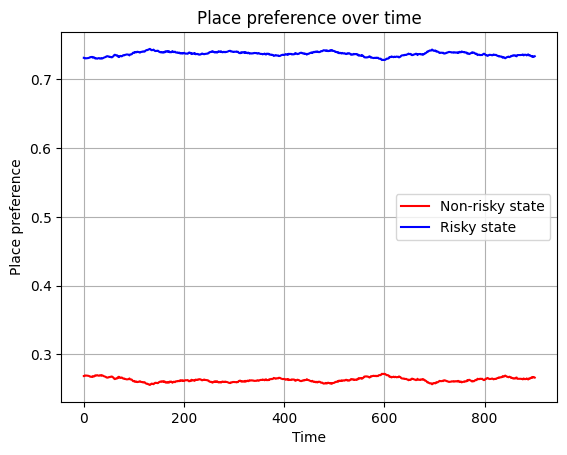

In [186]:
# Moyenne glissante pour lisser les courbes (optionnel)
def smooth_curve(data, window_size=100):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Lissage des préférences
smoothed_risky_preferences = smooth_curve(risky_preferences)
smoothed_non_risky_preferences = smooth_curve(non_risky_preferences)

# Tracer les courbes
plt.plot(smoothed_non_risky_preferences, label="Non-risky state", color="red")
plt.plot(smoothed_risky_preferences, label="Risky state", color="blue")
plt.xlabel("Time")
plt.ylabel("Place preference")
plt.title("Place preference over time")
plt.legend()
plt.grid()
plt.show()

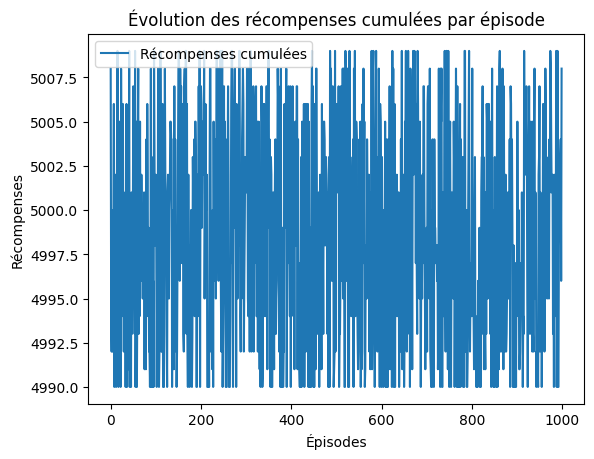

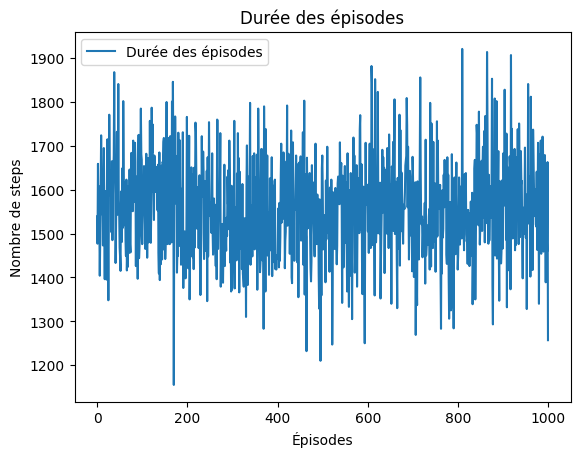

In [187]:
plt.plot(reward_history, label="Récompenses cumulées")
plt.xlabel("Épisodes")
plt.ylabel("Récompenses")
plt.title("Évolution des récompenses cumulées par épisode")
plt.legend()
plt.show()


episode_lengths = [len(states) for states in state_history]

plt.plot(episode_lengths, label="Durée des épisodes")
plt.xlabel("Épisodes")
plt.ylabel("Nombre de steps")
plt.title("Durée des épisodes")
plt.legend()
plt.show()

# average_internal_states = [sum(states) / len(states) for states in internal_states]

# plt.plot(average_internal_states, label="État interne moyen")
# plt.xlabel("Épisodes")
# plt.ylabel("Énergie interne moyenne")
# plt.title("Évolution de l'énergie interne au fil des épisodes")
# plt.legend()
# plt.show()

In [158]:
# action_counts = {0: 0, 1: 0}  # Compteurs pour les actions non risquées et risquées

# for episode_states in state_history:
#     for state in episode_states:
#         if state == 0:
#             action_counts[0] += 1
#         elif state == 1:
#             action_counts[1] += 1 # Affichage de la distribution des actions
# plt.bar(["Non Risqué", "Risqué"], [action_counts[0], action_counts[1]], color=["red", "blue"])
# plt.title("Distribution des actions prises")
# plt.ylabel("Nombre d'actions")
# plt.show()